In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 70
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [92]:
import woe

In [3]:
from utils import load_csv_compressed

accepted = load_csv_compressed('data/accepted_2007_to_2018Q4.csv')

### Предобработка некоторых столбцов

In [4]:
accepted.rename(columns={'loan_status': 'label'}, inplace=True)
accepted['label'] = accepted['label'].replace(('Fully Paid',
                                                'Charged Off',
                                                'Does not meet the credit policy. Status:Fully Paid',
                                                'Does not meet the credit policy. Status:Charged Off',
                                                'Default'),
                                                (0, 1, 0, 1, 1))

rows_with_other_labels = accepted[~accepted.label.isin([0, 1])].index
accepted.drop(index=rows_with_other_labels, inplace=True)

accepted['label'] = pd.to_numeric(accepted['label'])

for col in ['verification_status', 'verification_status_joint']:
    accepted[col] = accepted[col].map({'Not Verified': False, 'Source Verified': True})
    accepted[col] = accepted[col].astype(bool)

In [5]:
# Трансформируем даты
#def get_all_date_features(df):
#
#    date_features = []
#    for col in df:
#        if np.issubdtype(df[col].dtype, np.number):
#            continue
#
#        try:
#            pd.to_datetime(df[col].dropna().iloc[:10])
#            date_features.append(col)
#        except:
#            pass
#
#    return date_features
#
#
#date_features = get_all_date_features(accepted)
#accepted[date_features].apply(pd.to_datetime, inplace=True)
#accepted[date_features] = (accepted[date_features] - accepted['issue_d'])

### Отбор признаков

In [6]:
# Смотрим столбцы, которые необходимо удалить
df_rejected = pd.read_csv('docs/accepted_columns_description.csv')[['Column_name', 'Rejected']]

In [7]:
df_rejected

,Column_name,Rejected
0,acc_now_delinq,0
1,acc_open_past_24mths,0
2,addr_state,0
3,all_util,1
4,annual_inc,0
...,...,...
146,total_rev_hi_lim,0
147,url,1
148,verification_status,0
149,verified_status_joint,0


In [8]:
to_drop = df_rejected[df_rejected['Rejected'] == 1]['Column_name'].values

In [9]:
to_drop

array(['all_util', 'avg_cur_bal', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'deferral_term', 'desc',
       'disbursement_method', 'dti', 'dti_joint', 'funded_amnt',
       'funded_amnt_inv', 'grade', 'hardship_amount', 'hardship_dpd',
       'hardship_end_date', 'hardship_flag',
       'hardship_last_payment_amount', 'hardship_length',
       'hardship_loan_status', 'hardship_payoff_balance_amount',
       'hardship_reason', 'hardship_start_date', 'hardship_status',
       'hardship_type', 'id', 'il_util', 'initial_list_status', 'inq_fi',
       'inq_last_12m', 'inq_last_6mths', 'installment', 'int_rate',
       'issue_d', 'last_credit_pull_d', 'last_fico_range_high',
       'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d',
       'loan_amnt', 'max_bal_bc', 'member_id', 'mths_since_last_delinq',
       'mths_since_last_major_derog', 'mths_since_last_record',
       'mths_since_rcnt_il', 'mths_since_recent_bc_dlq',
       'mths_since_recent_revol_delinq', 'nex

In [10]:
accepted = accepted.drop(columns=to_drop)

In [103]:
accepted.columns

Index(['term', 'home_ownership', 'annual_inc', 'verification_status', 'label',
       'purpose', 'fico_range_low', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'mths_since_recent_inq', 'num_actv_rev_tl',
       'percent_bc_gt_75'],
      dtype='object')

In [11]:
# # Используем словарь значений столбцов (файл docs/accepted_columns_description.xlsx)
# to_drop = ['id', 'member_id', 'url', 'zip_code', 'desc', 'disbursement_method', # Useless
#            'emp_length',  # Распределение по таргету и рок аук так себе
#            'num_tl_120dpd_2m', 'policy_code',  # Одно значение
#            'grade', 'sub_grade',  # Результаты скоринга / данные после начала кредитования
#            'settlement_percentage', 'settlement_term', 'debt_settlement_flag',
#            'settlement_status', 'settlement_amount', 'term',
#            'loan_amnt', 'installment', 'total_rec_int', 'last_pymnt_amnt',
#            'deferral_term', 'title', 'pymnt_plan',
#            'sec_app_open_act_il', 'orig_projected_additional_accrued_interest',
#            'hardship_amount', 'hardship_dpd', 'hardship_flag',
#            'hardship_last_payment_amount', 'hardship_last_payment_amount',
#            'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount',
#            'hardship_reason', 'hardship_status', 'hardship_type',
#            'initial_list_status',
#            'earliest_cr_line', 'next_pymnt_d', 'sec_app_earliest_cr_line', 'hardship_start_date',  # Даты
#            'hardship_end_date', 'payment_plan_start_date', 'debt_settlement_flag_date', 'settlement_date',
#            'issue_d', 'last_pymnt_d', 'last_credit_pull_d',
#            ]

# # Пока что не выкинуты
# probably_leakage = ['sec_app_fico_range_high', 'sec_app_fico_range_high']

# accepted.drop(columns=to_drop, inplace=True, errors='ignore')

In [12]:
print('Колво уникальных значений:')

unique_counts_df = pd.DataFrame({'col': col,
                                 'unique_count': len(accepted[col].value_counts())} for col in accepted)

unique_counts_df.sort_values('unique_count')

Колво уникальных значений:


,col,unique_count
0,term,2
5,verification_status,2
6,label,2
21,verification_status_joint,2
19,application_type,2
3,home_ownership,6
22,acc_now_delinq,8
29,chargeoff_within_12_mths,11
2,emp_length,11
50,pub_rec_bankruptcies,12


### Работа с пропущенными значениями

In [59]:
fill_max = ['bc_open_to_buy',
            'mths_since_last_delinq',
            'mths_since_last_major_derog',
            'mths_since_last_record',
            'mths_since_rcnt_il',
            'mths_since_recent_bc',
            'mths_since_recent_bc_dlq',
            'mths_since_recent_inq',
            'mths_since_recent_revol_delinq',
            'pct_tl_nvr_dlq',
            'sec_app_mths_since_last_major_derog']

fill_mean = ['annual_inc', 'dti', 'fico_range_low', 'fico_range_high',
             'total_rev_hi_lim', 'total_bc_limit', 'total_il_high_credit_limit',
             'tot_hi_cred_lim', 'il_util', 'sec_app_revol_util', 'bc_util', 'term',
            'collection_recovery_fee', 'annual_inc_joint', 'acc_now_delinq', 'tot_coll_amt',
             'tot_cur_bal', 'delinq_amnt', 'num_bc_tl', ''
            ]

fill_median = ['emp_title', 'emp_length', 'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec',
              'total_acc', 'collections_12_mths_ex_med', 'acc_open_past_24mths', 'chargeoff_within_12_mths',
              'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
               'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 
               'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_sats', 'num_tl_op_past_12m', 
               'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 
               ''
              ]

fill_min = list(set(accepted.columns) - set(fill_max) - set(fill_mean) - {'label'})


for cols, func in zip([fill_min, fill_mean, fill_max],
                      [lambda x: np.min(x, axis=0), lambda x: np.mean(x, axis=0), lambda x: np.max(x, axis=0)]):
    try:
        fillna_vals = func(accepted[cols])
        accepted[cols] = accepted[cols].fillna(fillna_vals)
    except KeyError:
        continue

In [60]:
# # Смотрим описание столбцов
# notes_df = pd.read_excel('docs/accepted_columns_description.xlsx', engine='openpyxl')[['Column_name', 'Description']]
# notes_df = notes_df.dropna()

# for col in fill_min:
#     res = notes_df[notes_df['Column_name'].str.contains(col)]
#     for i, row in res.iterrows():
#         if accepted[col].isna().mean() == 0:
#             continue

#         print(row['Column_name'], '-', row['Description'])
#         print()

#     if not res.shape[0]:
#         print(col, '- no description found')
#         print()

### Трансформация признаков

In [61]:
col = 'pub_rec_bankruptcies'
accepted[col][accepted[col] == 'acc_now_delinq'] = 1
accepted['was_person_bankrupt'] = (accepted[col].astype(int) >= 1)
accepted.drop(columns=col, inplace=True)

/data/iasviridov/work/chest/chest/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [62]:
categorical = accepted.select_dtypes(exclude=[np.number, np.int64, bool]).columns
print(f'Категориальные признаки: {", ".join(categorical)}')

Категориальные признаки: term, emp_title, emp_length, home_ownership, purpose, title, addr_state, earliest_cr_line, application_type


#### emp_title

In [63]:
accepted['emp_title'] = accepted['emp_title'].str.lower()
accepted['emp_title'].value_counts()

teacher                                    25691
manager                                    24898
owner                                      15489
registered nurse                           12092
driver                                     11439
                                           ...  
state of maryland- salisbury university        1
citringroup                                    1
rba                                            1
sr. acct exec                                  1
tool & die manager                             1
Name: emp_title, Length: 327845, dtype: int64

In [64]:
# Аббревиатура и расшифровка
abbr_to_occupation = {}

occupations = accepted['emp_title'].value_counts(ascending=True).index

for occ in occupations:
    occ_split = occ.split()

    if len(occ_split) < 2:
        continue

    abbr = ''.join([s[0] for s in occ_split])
    abbr_to_occupation[abbr] = occ

accepted['emp_title'] = [abbr_to_occupation.get(occ, occ) for occ in accepted['emp_title']]
accepted['emp_title'].value_counts()

teacher                           25691
manager                           24898
registered nurse                  21697
owner                             15489
driver                            11439
                                  ...  
city of pasco                         1
assembly/ property maintenence        1
software asset mgr                    1
surf club                             1
tool & die manager                    1
Name: emp_title, Length: 324167, dtype: int64

In [65]:
selected_jobs = accepted['emp_title'].value_counts().index[:20]

not_selected_jobs_mask = ~accepted['emp_title'].isin(selected_jobs)
accepted['emp_title'][not_selected_jobs_mask] = 'other'
accepted['emp_title'].value_counts()

/data/iasviridov/work/chest/chest/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


other                 1157916
teacher                 25691
manager                 24898
registered nurse        21697
owner                   15489
driver                  11439
supervisor              11050
sales                   10467
project manager          7539
general manager          7458
office manager           7416
truck driver             6034
director                 5446
engineer                 5088
president                4961
vice president           4943
sales manager            4558
operations manager       4232
police officer           4132
store manager            3886
accountant               3759
Name: emp_title, dtype: int64

#### purpose

In [66]:
accepted['purpose'].value_counts()

debt_consolidation    781442
credit_card           295625
home_improvement       87721
other                  78301
major_purchase         29550
medical                15614
small_business         15577
car                    14652
moving                  9526
vacation                9084
house                   7298
wedding                 2350
renewable_energy         936
educational              423
Name: purpose, dtype: int64

In [67]:
purpose_map = {purp: purp for purp
                      in accepted['purpose'].value_counts().index}
purpose_map['home_improvement'] = 'consumer_expenses'
purpose_map['car'] = 'consumer_expenses'
purpose_map['vacation'] = 'consumer_expenses'
purpose_map['wedding'] = 'consumer_expenses'

accepted['purpose'] = accepted['purpose'].map(purpose_map)
accepted['purpose'].value_counts()

debt_consolidation    781442
credit_card           295625
consumer_expenses     113807
other                  78301
major_purchase         29550
medical                15614
small_business         15577
moving                  9526
house                   7298
renewable_energy         936
educational              423
Name: purpose, dtype: int64

#### addr_state

In [68]:
col = 'addr_state'

us_state_to_urbanization = pd.read_excel('docs/us_urbanization.xlsx', index_col=0)['Urbanization']

accepted['addr_urbanization'] = accepted[col].map(us_state_to_urbanization)
accepted.drop(columns=col, inplace=True)

#### application_type

In [69]:
col = 'application_type'

accepted['is_joint'] = (accepted[col] == 'Joint App')
accepted.drop(columns=col, inplace=True)

In [70]:
categorical = accepted.select_dtypes(exclude=[np.number, np.int64, bool]).columns
print(f'Категориальные признаки: {", ".join(categorical)}')

Категориальные признаки: term, emp_title, emp_length, home_ownership, purpose, title, earliest_cr_line


#### title

In [71]:
accepted.title.fillna('', inplace=True)

In [72]:
def rename_col(x):
    if x == '':
        return 'other'
    elif 'consolidation' in x.lower():
        return 'consolidation'
    elif 'home' in x.lower() or 'house' in x.lower():
        return 'house'
    elif 'car' in x.lower():
        return 'car'
    elif 'medic' in x.lower():
        return 'medical'
    elif 'vacation' in x.lower() or 'travel' in x.lower() or 'moving' in x.lower():
        return 'travel'
    elif 'major' in x.lower() or 'business' in x.lower():
        return 'business'
    else:
        return 'other'

In [73]:
accepted['title_classes'] = accepted['title'].apply(lambda x: rename_col(x))

In [74]:
accepted.drop(columns = ['title'], inplace=True)

In [75]:
accepted['title_classes']

0          consolidation
1               business
2                  other
4               business
5          consolidation
               ...      
2260688            house
2260690    consolidation
2260691            house
2260692          medical
2260697    consolidation
Name: title_classes, Length: 1348099, dtype: object

#### earliest_cr_line

In [76]:
accepted['earliest_cr_line_year'] = pd.to_datetime(accepted['earliest_cr_line']).dt.year
accepted.drop(columns=['earliest_cr_line'], inplace=True)

### Отбор по корреляции

In [77]:
# Смотрим корреляции Спирмена численных признаков
corrs = accepted.drop(columns='label').corr(method='spearman').abs()
# Формируем верхнетреугольную матрицу для устранения дубликатов
triupper_mask = np.triu(np.full(corrs.shape, True))
corrs = corrs.where(triupper_mask).stack().reset_index()
# Переводим в удобный формат и сортируем, а также удаляем единичные корреляции
corrs = corrs.rename(columns={
    'level_0': '1_feature',
    'level_1': '2_feature',
    0: 'value'})
corrs = corrs.sort_values(by='value', ascending=False)
corrs = corrs[corrs['1_feature'] != corrs['2_feature']]

In [78]:
corrs.head(10)

,1_feature,2_feature,value
142,fico_range_low,fico_range_high,1.000000
607,tot_cur_bal,tot_hi_cred_lim,0.974669
261,open_acc,num_sats,0.942088
641,total_rev_hi_lim,total_bc_limit,0.868138
731,bc_util,percent_bc_gt_75,0.864988
987,num_actv_bc_tl,num_bc_sats,0.841202
1072,num_op_rev_tl,num_sats,0.833676
311,pub_rec,was_person_bankrupt,0.826226
1042,num_bc_tl,num_rev_accts,0.826183
1008,num_actv_rev_tl,num_op_rev_tl,0.813604


In [79]:
# Если между признаками корреляция более 0.6 (эмпирический порог), то удаляем наименее коррелирующий с таргетом
to_drop = []

for _, row in corrs[corrs['value'] >= 0.6].iterrows():

    feature1, feature2 = row[['1_feature', '2_feature']]
    feature1_label_corr = accepted[[feature1, 'label']].corr(method='spearman')[feature1]['label']
    feature2_label_corr = accepted[[feature2, 'label']].corr(method='spearman')[feature2]['label']

    if feature1_label_corr >= feature2_label_corr:
        to_drop.append(row['2_feature'])
    else:
        to_drop.append(row['1_feature'])

to_drop = np.unique(to_drop)
accepted.drop(columns=to_drop, inplace=True)

In [80]:
# Также удалим фичи, сильно коррелирующие с таргетом по аналогичному порогу
to_drop = []

for col_name in (accepted.dtypes[accepted.dtypes == 'float32'].index):
    corr_tmp = abs(accepted[[col_name, 'label']].corr(method='spearman')[col_name]['label'])
    if corr_tmp >= 0.6:
        print('High correlation between target and {0} = {1:1.2f}!'.format(col_name, corr_tmp))
        to_drop.append(col_name)

to_drop = np.unique(to_drop)
accepted.drop(columns=to_drop, inplace=True) 

High correlation between target and collection_recovery_fee = 0.78!


In [81]:
accepted.shape

(1348099, 31)

In [82]:
print(sorted(accepted.columns))

['acc_open_past_24mths', 'addr_urbanization', 'annual_inc', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'earliest_cr_line_year', 'emp_length', 'emp_title', 'fico_range_low', 'home_ownership', 'is_joint', 'label', 'mo_sin_old_il_acct', 'mo_sin_rcnt_rev_tl_op', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_rev_tl', 'num_il_tl', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec', 'purpose', 'tax_liens', 'term', 'title_classes', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'verification_status']


### WoE для категориальных признаков

In [83]:
# Получаем список категориальных признаков
categ = list(accepted.dtypes[accepted.dtypes != 'float32'].index)
categ.remove('label')

In [84]:
categ

['term',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_urbanization',
 'is_joint',
 'title_classes',
 'earliest_cr_line_year']

In [85]:
# Получаем WoE, а также Information value
final_iv, IV = woe.data_vars(accepted[categ], accepted.label)

In [86]:
# Information value
IV

,VAR_NAME,IV
0,addr_urbanization,0.001521
1,earliest_cr_line_year,0.015806
2,emp_length,0.012031
3,emp_title,0.008214
4,home_ownership,0.031179
5,is_joint,0.001515
6,purpose,0.018743
7,term,0.173622
8,title_classes,0.013989
9,verification_status,0.050035


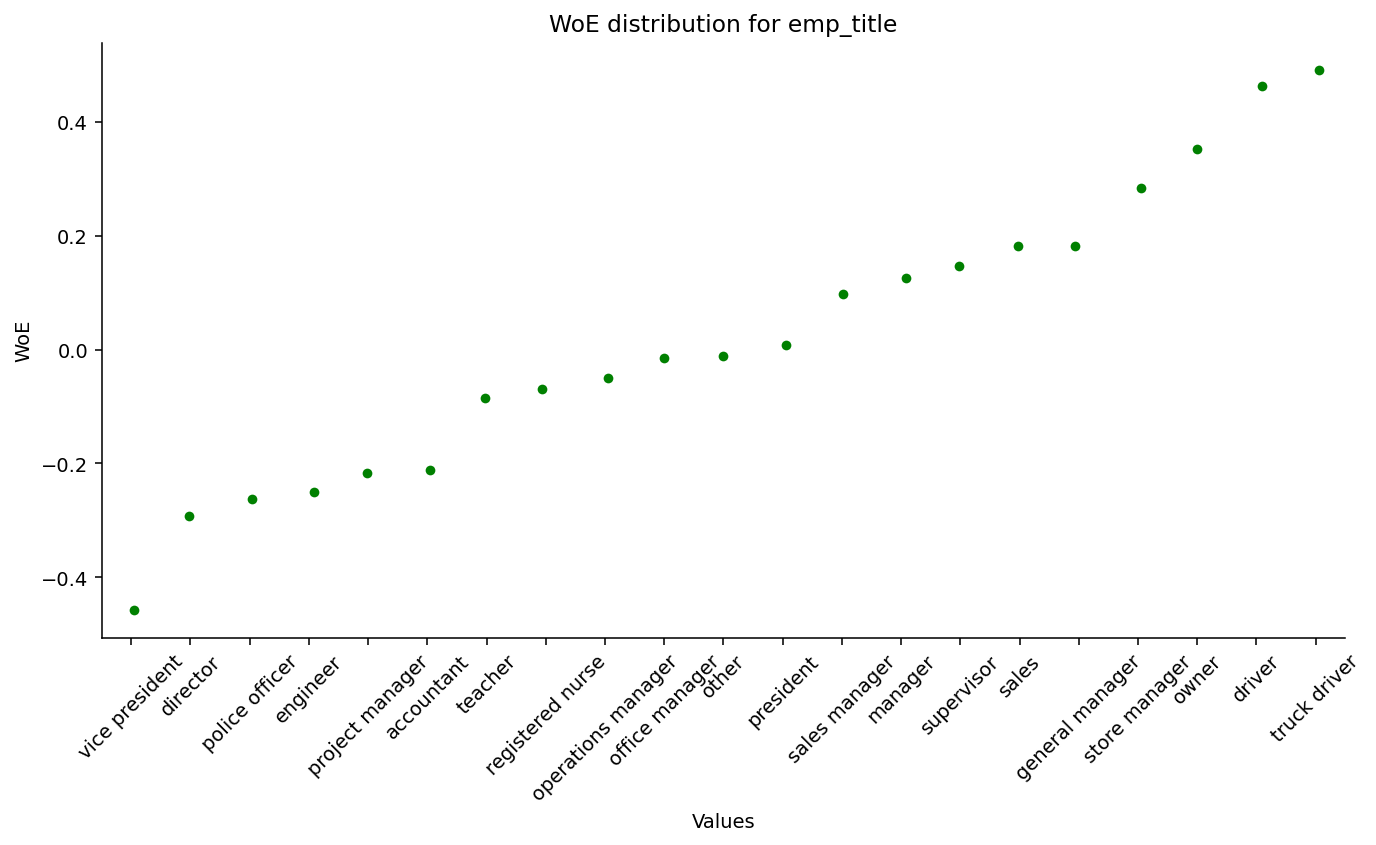

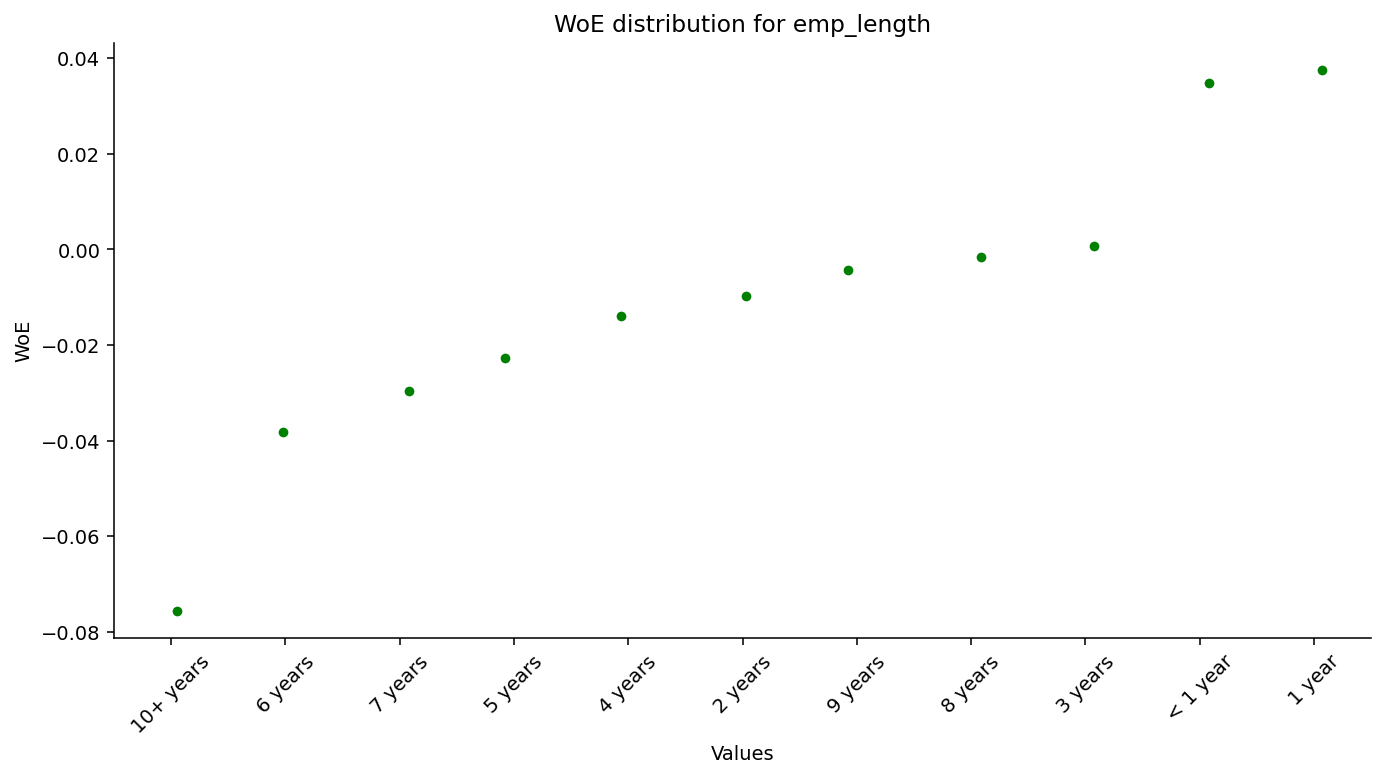

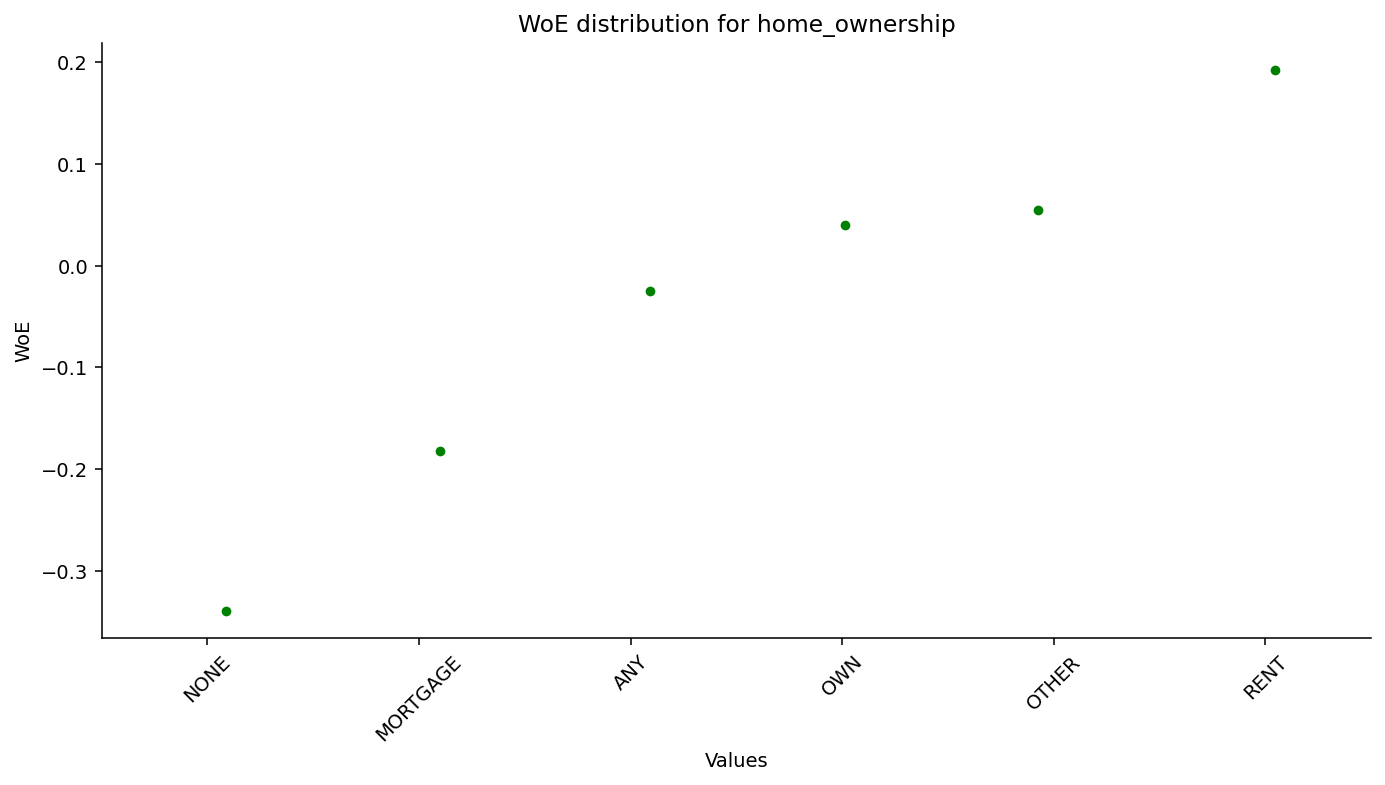

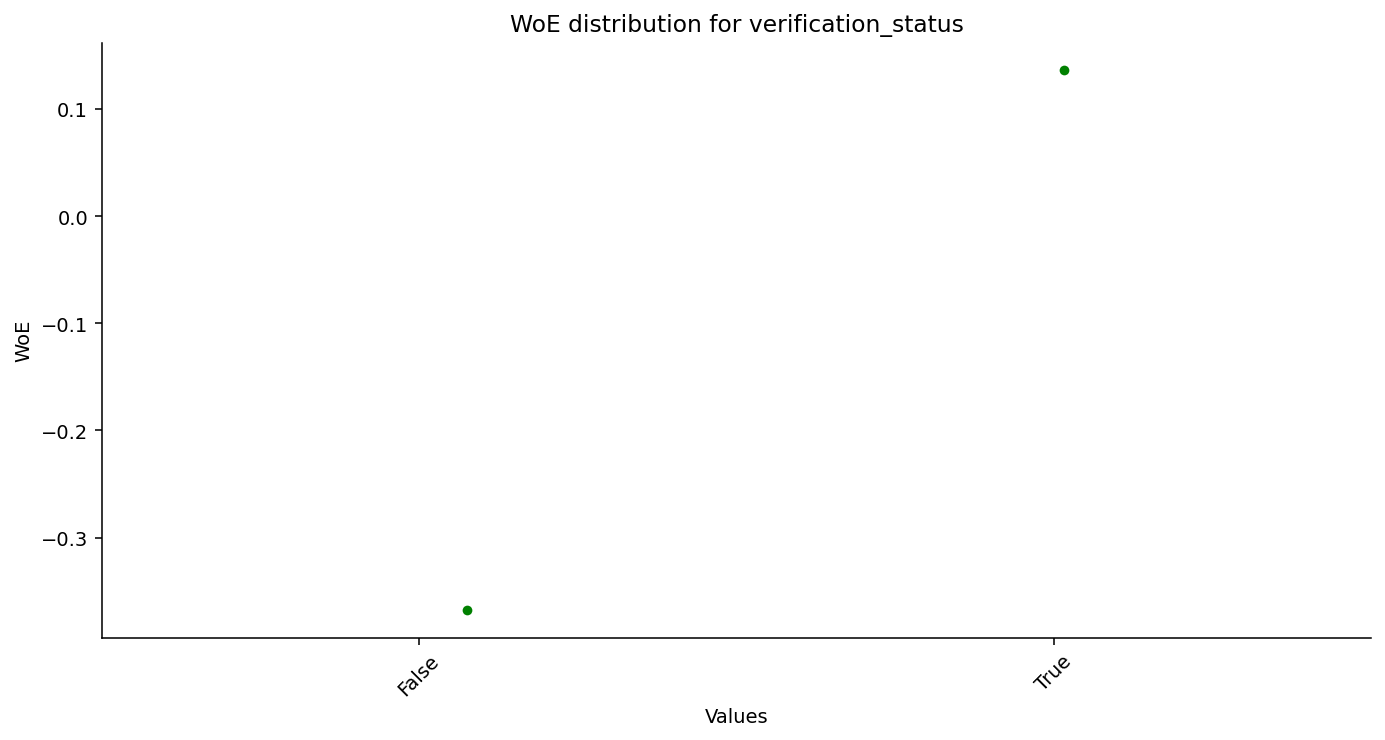

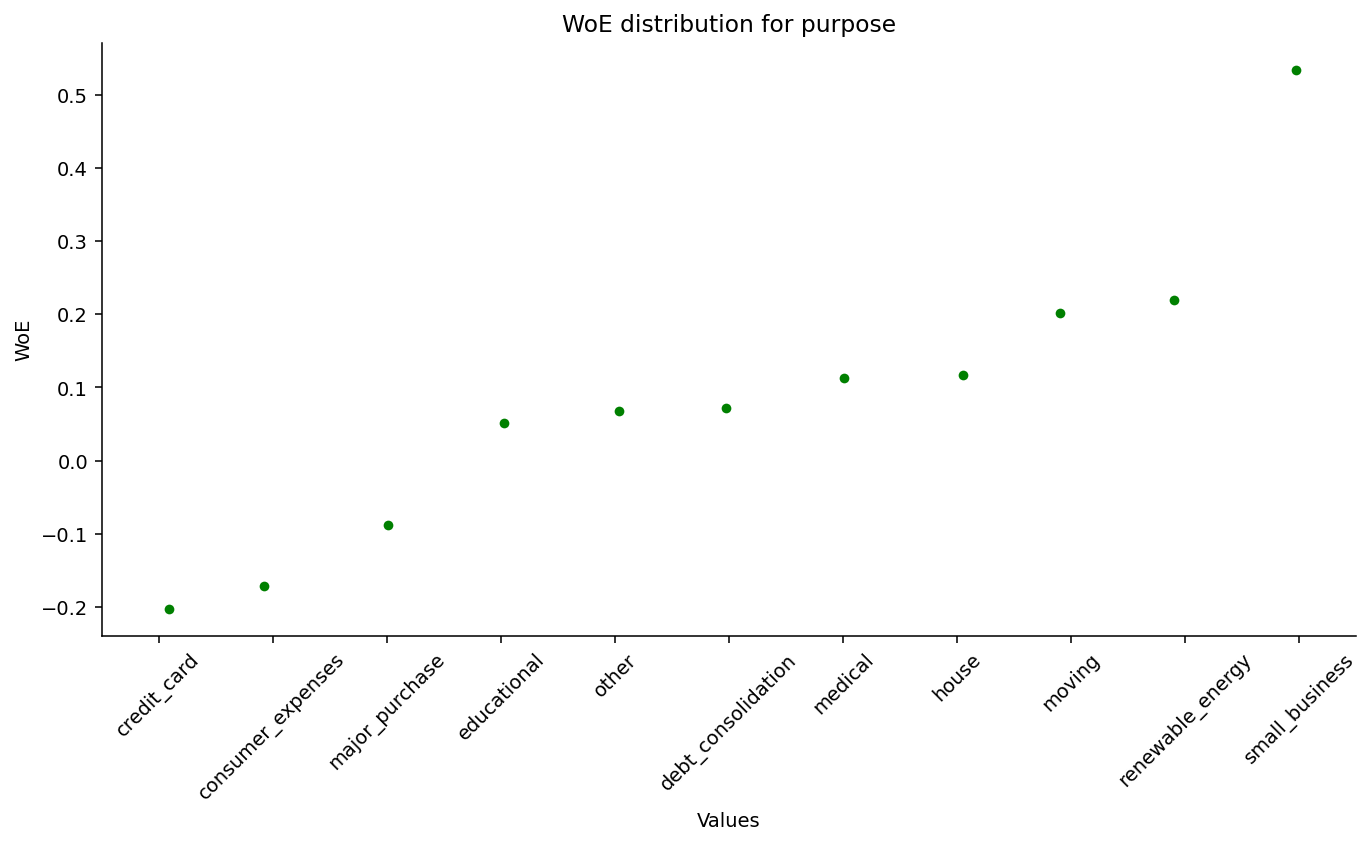

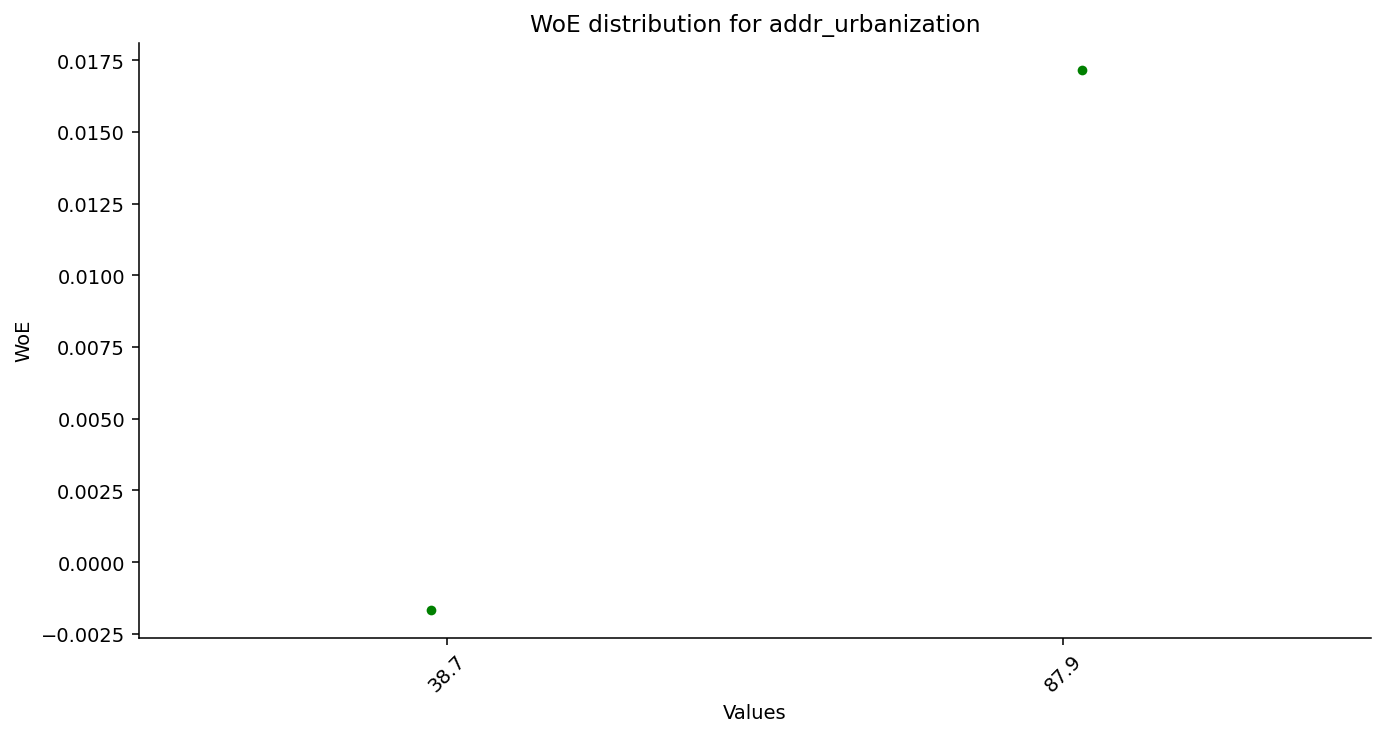

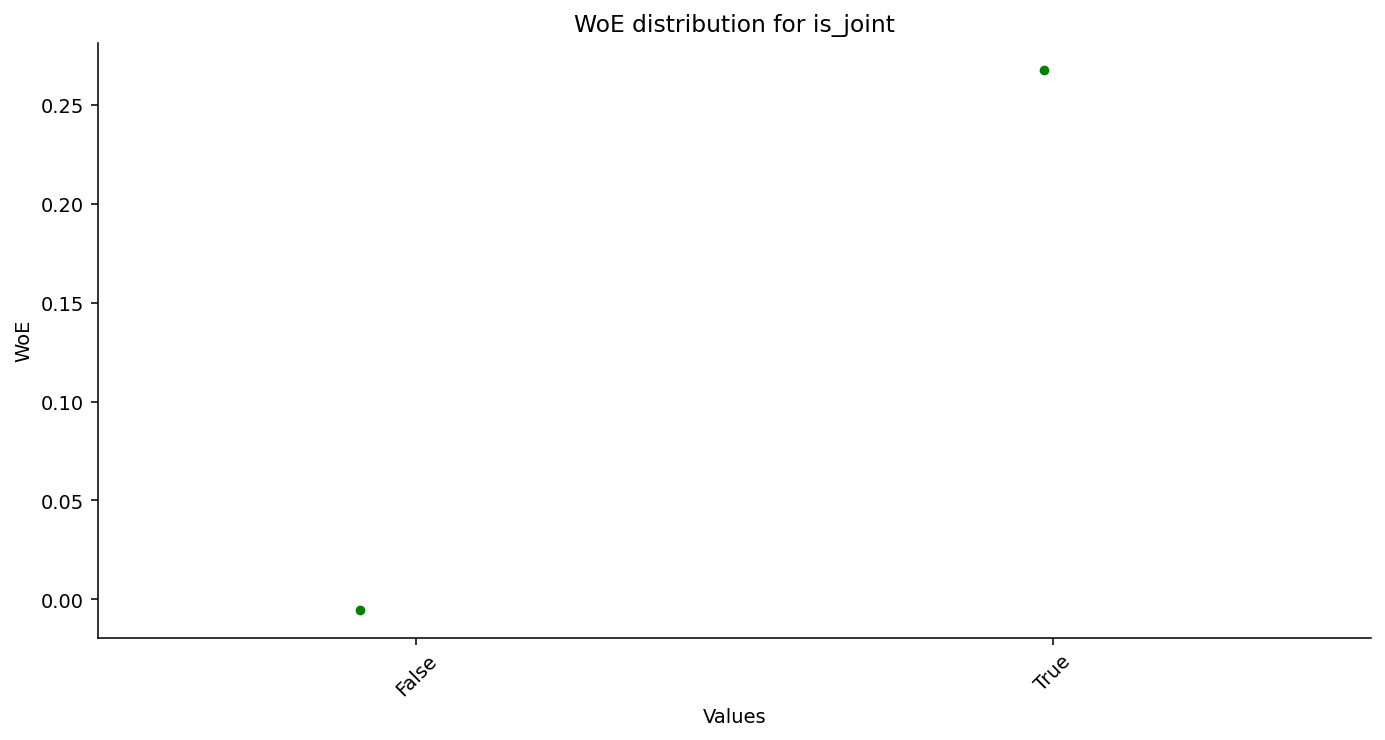

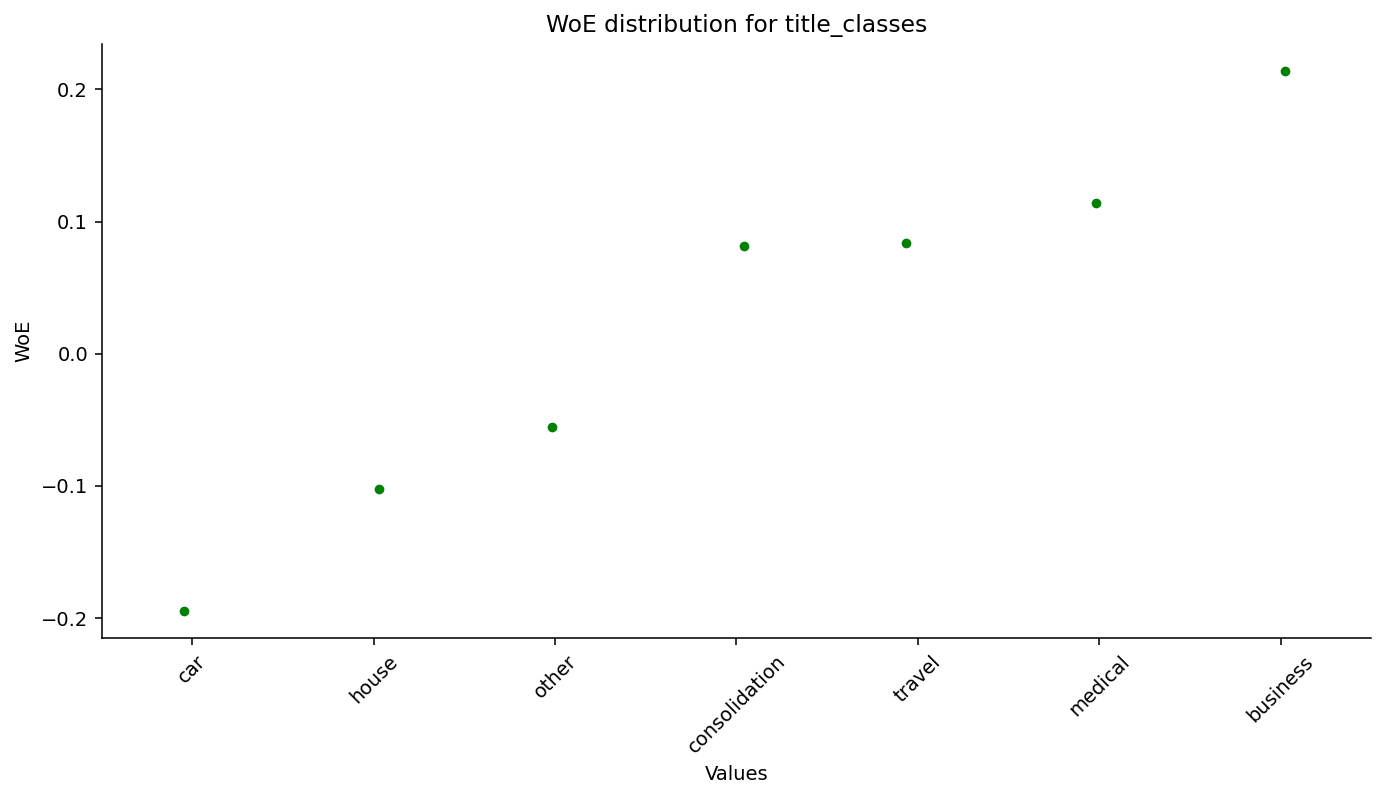

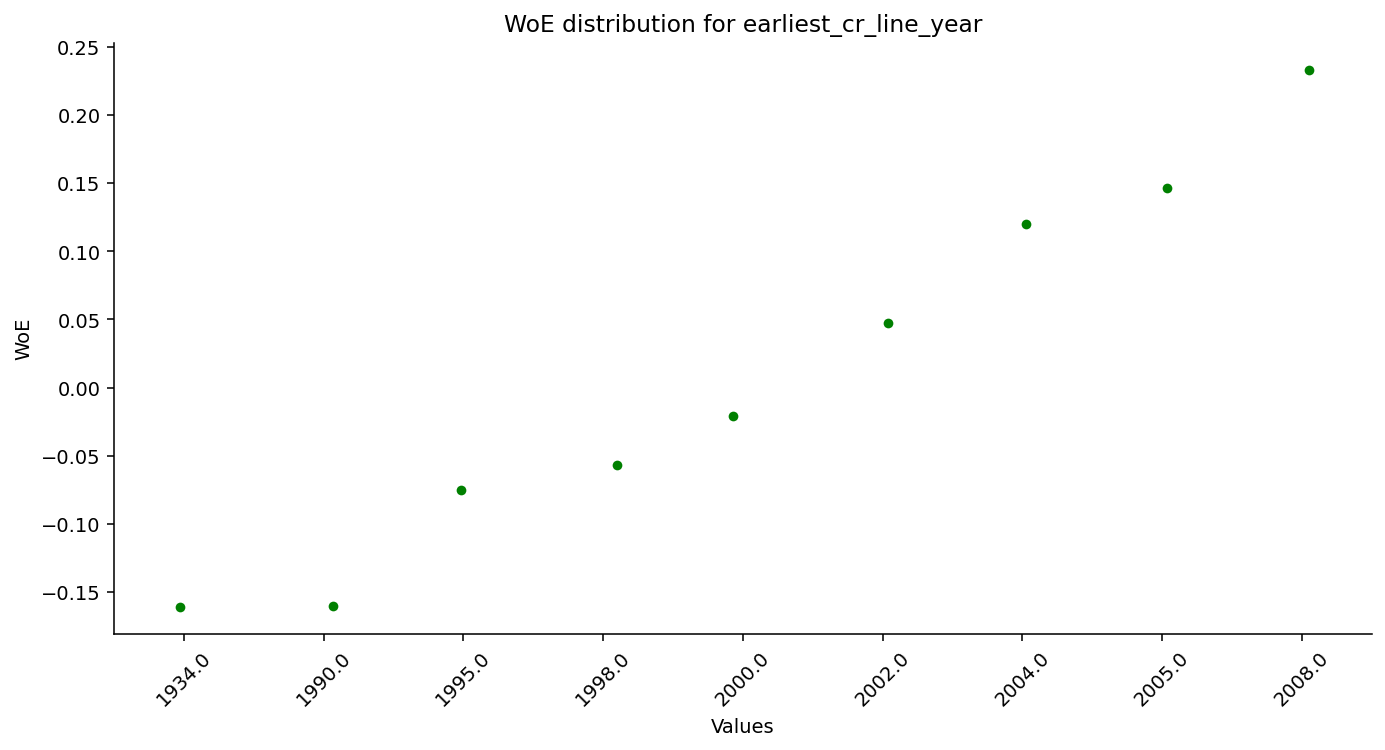

In [93]:
for col_name in categ:
    g = sns.catplot(x="MIN_VALUE", y="WOE", 
                    data=final_iv[final_iv['VAR_NAME'] == col_name].sort_values(by='WOE'), 
                    color='green', height=5, aspect=2).set(title='WoE distribution for ' + col_name)
    g.set_xticklabels(rotation=45)
    g.set(xlabel='Values', ylabel='WoE')

In [87]:
to_drop = IV[~(IV['IV'] >= 0.018)&(IV['IV'] <= 0.52)]['VAR_NAME'].values

In [88]:
to_drop

array(['addr_urbanization', 'earliest_cr_line_year', 'emp_length',
       'emp_title', 'is_joint', 'title_classes'], dtype=object)

In [89]:
accepted.drop(columns=to_drop, inplace=True)

## WoE для численных признаков

In [93]:
# Получаем список численных признаков
numeric = list(accepted.dtypes[accepted.dtypes == 'float32'].index)

In [94]:
numeric

['annual_inc',
 'delinq_2yrs',
 'fico_range_low',
 'pub_rec',
 'collections_12_mths_ex_med',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_rcnt_rev_tl_op',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_rev_tl',
 'num_il_tl',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'tax_liens']

In [95]:
# Получаем WoE, а также Information value
final_iv, IV = woe.data_vars(accepted[numeric], accepted.label)

/data/iasviridov/work/chest/chest/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [96]:
# Information value
IV

,VAR_NAME,IV
0,acc_open_past_24mths,6.373467e-02
1,annual_inc,2.876883e-02
2,chargeoff_within_12_mths,4.955945e-12
3,collections_12_mths_ex_med,1.884442e-04
4,delinq_2yrs,1.886255e-03
5,delinq_amnt,1.546421e-04
6,fico_range_low,1.215499e-01
7,mo_sin_old_il_acct,2.521786e-03
8,mo_sin_rcnt_rev_tl_op,1.627975e-02
9,mths_since_recent_inq,3.541078e-02


In [97]:
to_drop = IV[~(IV['IV'] >= 0.018)&(IV['IV'] <= 0.52)]['VAR_NAME'].values

In [98]:
to_drop

array(['chargeoff_within_12_mths', 'collections_12_mths_ex_med',
       'delinq_2yrs', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_rcnt_rev_tl_op', 'num_accts_ever_120_pd', 'num_il_tl',
       'pct_tl_nvr_dlq', 'pub_rec', 'tax_liens', 'tot_coll_amt'],
      dtype=object)

In [99]:
accepted.drop(columns=to_drop, inplace=True)

In [100]:
accepted.columns

Index(['term', 'home_ownership', 'annual_inc', 'verification_status', 'label',
       'purpose', 'fico_range_low', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'mths_since_recent_inq', 'num_actv_rev_tl',
       'percent_bc_gt_75'],
      dtype='object')

### Pipeline

In [73]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomColumnTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, us_urbanization_xlsx_path='docs/us_urbanization.xlsx'):
        self.cols = ['funded_amnt', 'int_rate', 'emp_title', 'home_ownership', 'annual_inc',
                     'verification_status', 'purpose', 'dti', 'delinq_2yrs',
                     'fico_range_high', 'inq_last_6mths', 'pub_rec', 'revol_bal',
                     'out_prncp', 'total_rec_late_fee', 'recoveries', 'last_fico_range_low',
                     'collections_12_mths_ex_med', 'dti_joint', 'acc_now_delinq',
                     'tot_coll_amt', 'il_util', 'open_rv_24m', 'total_cu_tl',
                     'acc_open_past_24mths', 'chargeoff_within_12_mths',
                     'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
                     'mths_since_recent_bc', 'mths_since_recent_revol_delinq',
                     'num_accts_ever_120_pd', 'num_actv_rev_tl', 'num_il_tl',
                     'num_tl_90g_dpd_24m', 'percent_bc_gt_75', 'tax_liens',
                     'sec_app_fico_range_low', 'sec_app_inq_last_6mths',
                     'sec_app_revol_util', 'sec_app_chargeoff_within_12_mths',
                     'sec_app_collections_12_mths_ex_med',
                     'sec_app_mths_since_last_major_derog', 'addr_state']

        self.fill_max_cols = ['bc_open_to_buy',
                              'mths_since_last_delinq', 'mths_since_last_major_derog',
                              'mths_since_last_record', 'mths_since_rcnt_il',
                              'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
                              'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
                              'pct_tl_nvr_dlq', 'sec_app_mths_since_last_major_derog']

        self.fill_mean_cols = ['annual_inc', 'dti', 'sec_app_fico_range_low', 'sec_app_fico_range_high',
                               'total_rev_hi_lim', 'total_bc_limit', 'total_il_high_credit_limit',
                               'tot_hi_cred_lim', 'il_util', 'sec_app_revol_util', 'bc_util']

        self.fill_min_cols = None

        self.fill_dict = {}

        self.purpose_map = {'home_improvement': 'consumer_expenses',
                            'car': 'consumer_expenses',
                            'vacation': 'consumer_expenses',
                            'wedding': 'consumer_expenses'}

        self.us_urbanization_xlsx_path = us_urbanization_xlsx_path
        self.us_state_to_urbanization = pd.read_excel(us_urbanization_xlsx_path, index_col=0)['Urbanization']

    def fit(self, X, y=None):
        self.fit_or_transform(X, y, mode='fit')
        return self

    def transform(self, X, y=None):
        return self.fit_or_transform(X, y, mode='transform')

    def fit_or_transform(self, X, y=None, mode='fit'):
        assert mode in ['fit', 'transform']

        X = X[self.cols]

        X = self.transform_verification_status(X, 'verification_status')
        X = self.simple_impute(X, mode)
        X = self.transform_emp_title(X, 'emp_title', mode)
        X = self.transform_purpose(X, 'purpose')
        X = self.transform_addr_state(X, 'addr_state')

        return X

    @staticmethod
    def transform_verification_status(X, col):
        X[col] = X[col].map({'Not Verified': False, 'Source Verified': True})
        X[col] = X[col].astype(bool)
        return X

    def transform_emp_title(self, X, col, mode):
        # Аббревиатура и расшифровка
        if mode == 'fit':
            self.abbr_to_occupation = {}

            occupations = X['emp_title'].value_counts(ascending=True).index

            for occ in occupations:
                occ_split = occ.split()

                if len(occ_split) < 2:
                    continue

                abbr = ''.join([s[0] for s in occ_split])
                self.abbr_to_occupation[abbr] = occ

        X[col] = [self.abbr_to_occupation.get(occ, occ) for occ in X['emp_title']]

        if mode == 'fit':
            self.selected_jobs = X['emp_title'].value_counts().index[:20]

        not_selected_jobs_mask = ~X['emp_title'].isin(self.selected_jobs)
        X['emp_title'][not_selected_jobs_mask] = 'other'

        return X

    def transform_purpose(self, X, col):
        X[col] = [self.purpose_map.get(purp, purp) for purp in X[col]]
        return X

    def transform_addr_state(self, X, col):
        X['addr_urbanization'] = X[col].map(self.us_state_to_urbanization)
        X.drop(columns=col, inplace=True)
        return X

    def simple_impute(self, X, mode):

        if mode == 'fit':
            self.fill_max_cols = list(set(self.fill_max_cols) & set(X.columns))
            self.fill_mean_cols = list(set(self.fill_mean_cols) & set(X.columns))
            self.fill_min_cols = list(set(X.columns) - set(fill_max) - set(fill_mean))

        for cols, kind in zip([self.fill_min_cols, self.fill_mean_cols, self.fill_max_cols],
                              ['min', 'mean', 'max']):

            if mode == 'fit':
                self.fill_dict[kind] = eval(f'np.{kind}(X[cols], axis=0)')

            fillna_vals = self.fill_dict[kind]
            X[cols] = X[cols].fillna(fillna_vals)

        return X

In [59]:
numeric = accepted.select_dtypes(include=np.number).columns
categorical = accepted.select_dtypes(exclude=np.number).columns

In [15]:
import yaml

print(yaml.dump(accepted.columns.values.tolist(), explicit_start=True, default_flow_style=False))

---
- loan_amnt
- term
- int_rate
- emp_title
- emp_length
- home_ownership
- annual_inc
- verification_status
- loan_status
- purpose
- addr_state
- dti
- earliest_cr_line
- fico_range_high
- inq_last_6mths
- revol_bal
- initial_list_status
- out_prncp
- total_rec_late_fee
- collection_recovery_fee
- last_fico_range_low
- collections_12_mths_ex_med
- application_type
- tot_coll_amt
- avg_cur_bal
- bc_open_to_buy
- chargeoff_within_12_mths
- delinq_amnt
- mo_sin_old_il_acct
- mo_sin_old_rev_tl_op
- mo_sin_rcnt_tl
- mort_acc
- mths_since_recent_bc
- num_accts_ever_120_pd
- num_actv_bc_tl
- num_bc_tl
- num_il_tl
- num_sats
- num_tl_120dpd_2m
- num_tl_30dpd
- num_tl_90g_dpd_24m
- num_tl_op_past_12m
- pct_tl_nvr_dlq
- percent_bc_gt_75
- pub_rec_bankruptcies
- tax_liens
- total_il_high_credit_limit
- disbursement_method
- label



In [16]:
numeric = accepted.select_dtypes(include=np.number).columns.values.tolist()
categorical = accepted.select_dtypes(exclude=np.number).columns.values.tolist()

print(yaml.dump(numeric, explicit_start=True, default_flow_style=False))
print(yaml.dump(categorical, explicit_start=True, default_flow_style=False))

---
- loan_amnt
- int_rate
- annual_inc
- dti
- fico_range_high
- inq_last_6mths
- revol_bal
- out_prncp
- total_rec_late_fee
- collection_recovery_fee
- last_fico_range_low
- collections_12_mths_ex_med
- tot_coll_amt
- avg_cur_bal
- bc_open_to_buy
- chargeoff_within_12_mths
- delinq_amnt
- mo_sin_old_il_acct
- mo_sin_old_rev_tl_op
- mo_sin_rcnt_tl
- mort_acc
- mths_since_recent_bc
- num_accts_ever_120_pd
- num_actv_bc_tl
- num_bc_tl
- num_il_tl
- num_sats
- num_tl_120dpd_2m
- num_tl_30dpd
- num_tl_90g_dpd_24m
- num_tl_op_past_12m
- pct_tl_nvr_dlq
- percent_bc_gt_75
- pub_rec_bankruptcies
- tax_liens
- total_il_high_credit_limit
- label

---
- term
- emp_title
- emp_length
- home_ownership
- verification_status
- loan_status
- purpose
- addr_state
- earliest_cr_line
- initial_list_status
- application_type
- disbursement_method



In [2]:
from pipeline import get_preprocessing_pipeline

pipeline = get_preprocessing_pipeline(
    name='log_reg',
    overrides=[
        '+preprocessing_pipeline.steps_config.2.ImputeNumerical.inner.verbose=10',
        '+preprocessing_pipeline.steps_config.3.ImputeCategorical.inner.verbose=10',
    ],
    debug=True
)
pipeline

preprocessing_pipeline:
  _target_: pipeline.make_pipeline
  steps_config:
  - CSVReader:
      _target_: pipeline.CSVReader
      file: data/accepted_2007_to_2018Q4.csv
      columns:
      - loan_amnt
      - term
      - int_rate
      - emp_title
      - emp_length
      - home_ownership
      - annual_inc
      - verification_status
      - loan_status
      - purpose
      - addr_state
      - dti
      - earliest_cr_line
      - fico_range_high
      - inq_last_6mths
      - revol_bal
      - initial_list_status
      - out_prncp
      - total_rec_late_fee
      - collection_recovery_fee
      - last_fico_range_low
      - collections_12_mths_ex_med
      - application_type
      - tot_coll_amt
      - avg_cur_bal
      - bc_open_to_buy
      - chargeoff_within_12_mths
      - delinq_amnt
      - mo_sin_old_il_acct
      - mo_sin_old_rev_tl_op
      - mo_sin_rcnt_tl
      - mort_acc
      - mths_since_recent_bc
      - num_accts_ever_120_pd
      - num_actv_bc_tl
      - num_bc_

LabelInferPipeline(memory='./cache',
                   steps=[('ImputeNumerical',
                           ApplyToColumns(columns=['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_range_high', 'inq_last_6mths', 'revol_bal', 'out_prncp', 'total_rec_late_fee', 'collection_recovery_fee', 'last_fico_range_low', 'collections_12_mths_ex_med', 'tot_coll_amt', 'avg_cur_bal', 'bc_open_to_buy', 'chargeoff_within_1...
                           WingsOfEvidence(columns_to_apply=['loan_amnt', 'term', 'int_rate', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'purpose', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_high', 'inq_last_6mths', 'revol_bal', 'initial_list_status', 'out_prncp', 'total_rec_late_fee', 'collection_recovery_fee', 'last_fico_range_low', 'collections_12_mths_ex_med', 'application_type', 'tot_coll_amt', 'avg_cur_bal', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_r

In [ ]:
X = pipeline.fit_transform([], y=[])